# Reinforcement Learning Chess

### Monte Carlo tree search (MCTS)
The aim of this notebook is to build a chess AI that can plan moves and defeat a simple opponent in a regular game of chess. My approach can be summarized as follows:
- Instead of Q-learning (learning action values) I use "V-learning" (learning state-values).
    - An advantage is that the Neural Network can learn with fewer parameters since it doesn't need to learn a seperate value for each action. In my Q-learning and Policy Gradient notebook, the output vector has a size > 4000. Now the size is only 1.
- The V-network is updated using Temporal Difference (TD) Learning, like explained in Notebook 1. 
    - This option is the simplest to code.  Other options are TD-lambda and Monte Carlo Learning.
- The Architecture of the V-network is quite arbitrary and can probably be optimized. I used a combination of small and large convolutions, combined with convolutions that range a full file or rank (1-by-8 or 8-by-1).
- Moves are planned using Monte Carlo Tree Search. This involves simulating playouts. 
    - Monte Carlo Tree Search greatly improves performance on games like chess and go because it helps the agent to plan ahead.
- These playouts are truncated after N steps and bootstrapped. 
    - This reduces the variance of the simulation outcomes and gives performance gains, since the simulation doesn't require a full playout. 
- For this version, the opponent of the RL-agent is a myopic player, that always chooses the move that results in the most material on the board or a checkmate.

**Import**

In [1]:
# !pip install chess

     |████████████████████████████████| 141 kB 427 kB/s 
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%load_ext autoreload
%autoreload 2
# !pip install --upgrade git+https://github.com/arjangroen/RLC.git@maintain-tree  # RLC is the Reinforcement Learning package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import os
import inspect
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from keras.models import load_model

In [6]:
from RLC.real_chess import agent, environment, learn, tree
from endgame_environment import Board
import chess
from chess.pgn import Game

# these are FENS, which are a concise way of representing the board states
# 10 common end games were selected for training purposes
endgame_fens = [
    "8/8/8/8/4P3/8/8/4K3 w - - 0 1", # King and pawn vs. king
    "8/8/8/8/8/3K4/8/3Rk3 w - - 0 1", # King and rook vs king
    "8/8/8/4b3/8/4B3/8/4K1k1 w - - 0 1", # King and bishop vs king and bishop (opposite colors)
    "6k1/6p1/8/8/8/4Q3/8/6K1 w - - 0 1", # King and queen vs king and pawn
    "8/8/3K4/3N4/8/8/3B4/7k w - - 0 1", # King, knight, and bishop vs king
    "8/8/8/8/3r4/8/3k1K2/2B5 w - - 0 1", # King and bishop vs king and rook
    "6k1/8/8/8/8/4K3/8/1Q1r4 w - - 0 1", # King and queen vs king and rook
    "8/4k3/8/8/8/4P3/4K3/6NN w - - 0 1", # King, pawn, and two knights vs king
    "8/5r2/8/8/4K3/8/2Q2B2/8 w - - 0 1", # King, queen, and bishop vs king and rook
    "8/8/8/3n4/8/3K1N2/8/3Bkb2 w - - 0 1", # King, knight, and bishop vs king, knight, and bishop
]

opponent = agent.GreedyAgent()
env = Board(opponent, FEN=None, endgame_fens=endgame_fens)
player = agent.Agent(lr=0.0005,network='big')
learner = learn.TD_search(env, player,gamma=0.9,search_time=0.9)
node = tree.Node(learner.env.board, gamma=learner.gamma)
player.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state (InputLayer)              (None, 8, 8, 8)      0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 8, 8, 4)      36          state[0][0]                      
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 7, 7, 8)      264         state[0][0]                      
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 3, 3, 12)     876         state[0][0]                      
__________________________________________________________________________________________________
conv2d_11 

### Launching the network

In [7]:
n_iters = 1000000  # maximum number of iterations
timelimit = 3600 # maximum time for learning
network_replacement_interval = 10  # For the stability of the nearal network updates, the network is not continuously replaced



iter 0
game ended with result 0.0 and material balance 9.0 in 5 halfmoves
game ended with result 0.05 and material balance 12.0 in 5 halfmoves
game ended with result -0.01 and material balance 3.0 in 26 halfmoves
game ended with result 0.0 and material balance 0.0 in 1 halfmoves
game ended with result 0.0 and material balance 5.0 in 1 halfmoves
game ended with result 0.05 and material balance 9.0 in 5 halfmoves
game ended with result 0.05 and material balance 0.0 in 7 halfmoves
game ended with result 0.05 and material balance 0.0 in 9 halfmoves
game ended with result 0.05 and material balance 3.0 in 5 halfmoves
game ended with result 0.01 and material balance 0.0 in 25 halfmoves
iter 10
game ended with result -0.09 and material balance 0.0 in 8 halfmoves
game ended with result 0.03 and material balance 3.0 in 7 halfmoves
game ended with result 0.0 and material balance 0.0 in 1 halfmoves
game ended with result 0.03 and material balance -3.0 in 45 halfmoves
game ended with result -0.03

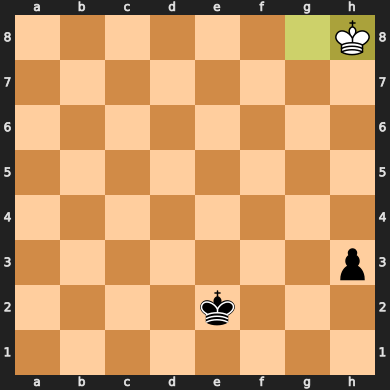

In [9]:
learner.learn(iters=n_iters,timelimit_seconds=timelimit,c=network_replacement_interval) 

### Learning performance 

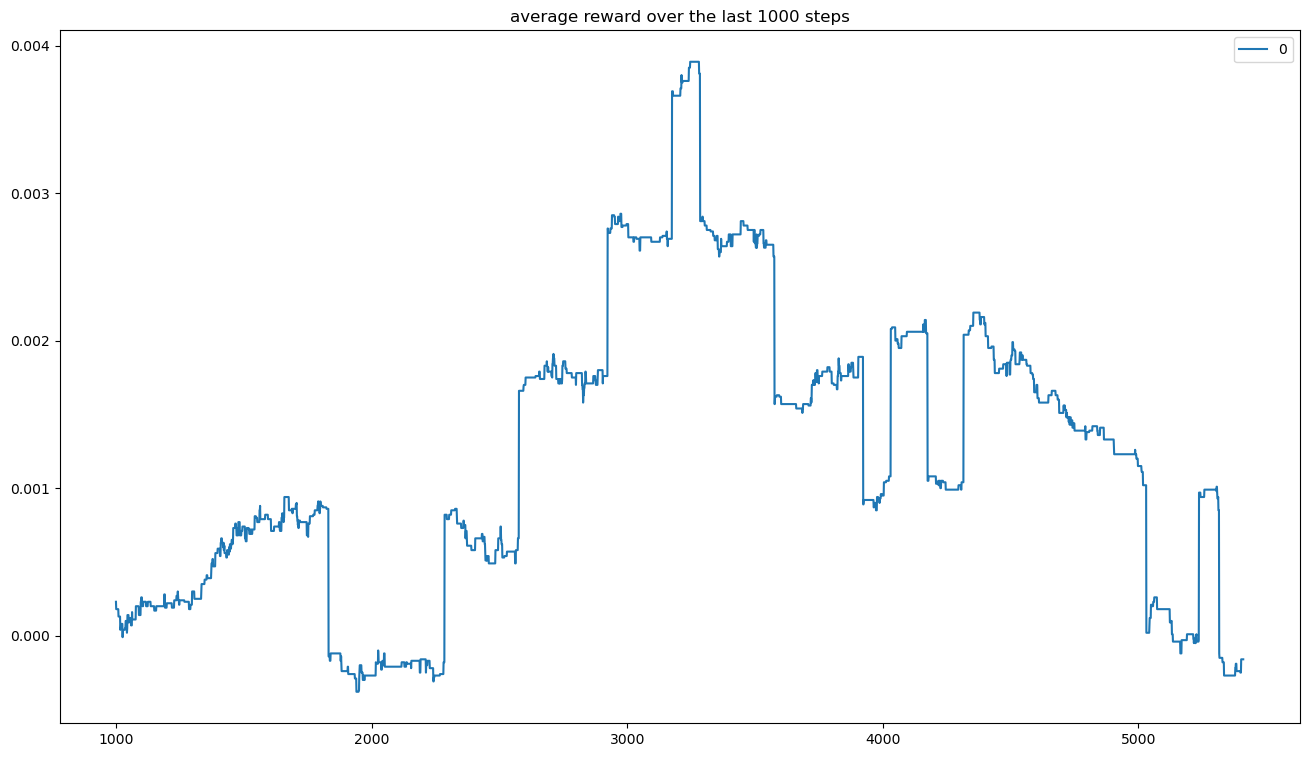

In [10]:
reward_smooth = pd.DataFrame(learner.reward_trace)
reward_smooth.rolling(window=1000,min_periods=1000).mean().plot(figsize=(16,9),title='average reward over the last 1000 steps')
plt.show()

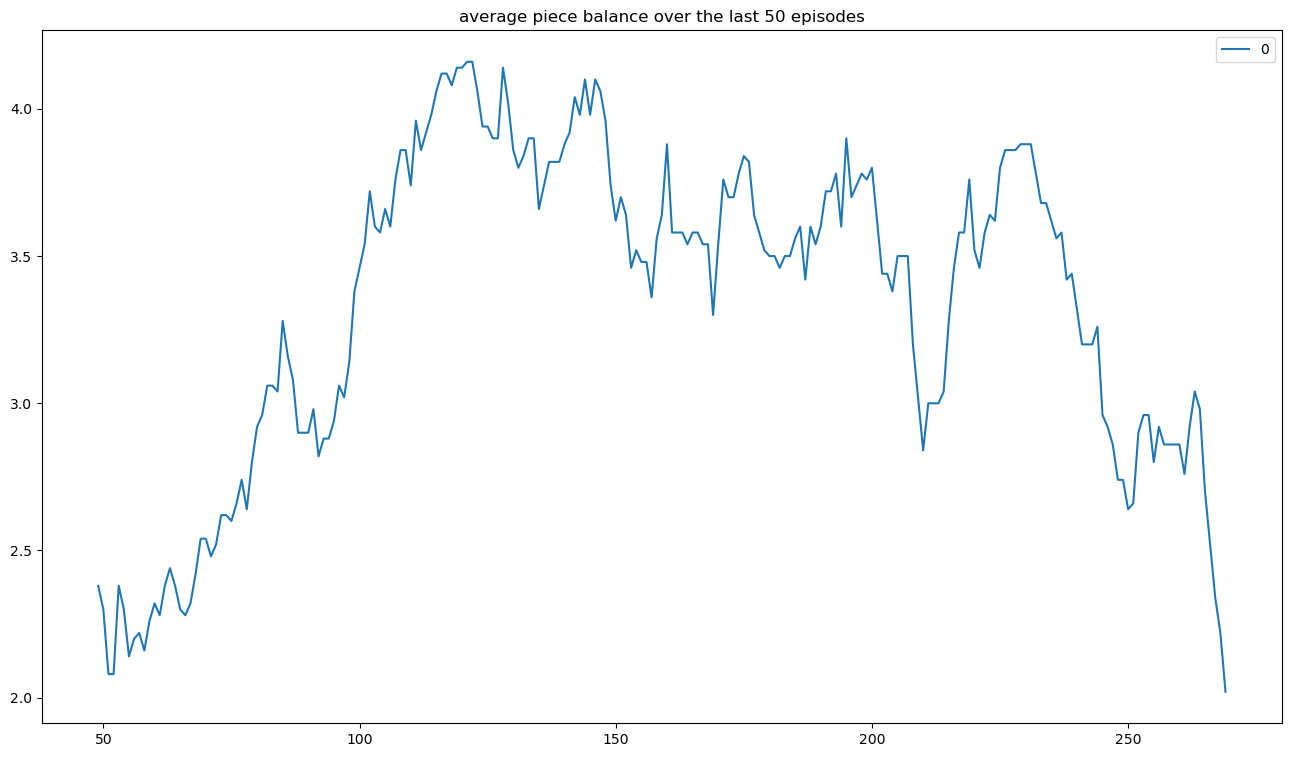

In [11]:
reward_smooth = pd.DataFrame(learner.piece_balance_trace)
reward_smooth.rolling(window=50,min_periods=50).mean().plot(figsize=(16,9),title='average piece balance over the last 50 episodes')
plt.show()

### Final performance with large searchtime and more greedy behavior

In [12]:
learner.env.reset()
learner.search_time = 100
learner.temperature = 1/3

In [13]:
learner.play_game(n_iters,maxiter=1000)

In [ ]:
pgn = Game.from_board(learner.env.board)
with open("rlc_pgn","w") as log:
    log.write(str(pgn))

In [ ]:
learner.agent.model.save('RLC_model.h5')